In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql import Row, DataFrame

from hops import hdfs
from tempfile import TemporaryFile

import pandas as pd
import numpy as np

import math
import seaborn as sns

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
419,application_1544087865774_0057,pyspark,idle,Link,Link,✔


SparkSession available as 'spark'.


In [2]:
%%local
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
import matplotlib.patches as mpatches
plt.style.use('seaborn-darkgrid')
%matplotlib inline 
xlabel_size = 80
ylabel_size = 80
font_size = 60
tick_size = 60
line_width = 20

plt.rc('font', **{'weight' : 'normal','size'   : font_size})

## Import Data

In [3]:
df_raw = spark.read.parquet('hdfs:///Projects/TrafficFlow/TrafficFlowParquet/TrafficFlowAll')

In [4]:
df_raw.printSchema()

root
 |-- Timestamp: timestamp (nullable = true)
 |-- Date: date (nullable = true)
 |-- Day: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)
 |-- Road: string (nullable = true)
 |-- Km_Ref: integer (nullable = true)
 |-- Detector_Number: integer (nullable = true)
 |-- Traffic_Direction: short (nullable = true)
 |-- Flow_In: short (nullable = true)
 |-- Average_Speed: short (nullable = true)
 |-- Density: double (nullable = true)
 |-- Sign_Aid_Det_Comms: short (nullable = true)
 |-- Status: short (nullable = true)
 |-- Legend_Group: short (nullable = true)
 |-- Legend_Sign: short (nullable = true)
 |-- Legend_SubSign: short (nullable = true)
 |-- Protocol_Version: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)

In [5]:
metadata_schema = StructType() \
        .add('Y', DoubleType(), False) \
        .add('X', DoubleType(), False) \
        .add('DetectorId', ShortType(), False) \
        .add('McsDetecto', ShortType(), False) \
        .add('McsDsRefer', StringType(), False) \
        .add('LaneId', ShortType(), False) \
        .add('Bearing', ShortType(), True) \
        .add('Location', StringType(), True) \
        .add('RegionId', ShortType(), False) \
        .add('Entreprene', StringType(), True) \
        .add('StationId', ShortType(), False) \
        .add('SiteId', ShortType(), False) \
        .add('SiteValidF', TimestampType(), False) \
        .add('SiteValidT', TimestampType(), False) \
        .add('DetectorVa', TimestampType(), False) \
        .add('Detector_1', TimestampType(), False)

In [6]:
df_metadata_raw = spark.read.csv(
    'hdfs:///Projects/traffic_reginbald/processed_traffic_data/StockholmDetectorMetadata.csv', 
    sep=';', 
    schema=metadata_schema,
    ignoreLeadingWhiteSpace=True,
    ignoreTrailingWhiteSpace=True,
    header=True,
    timestampFormat='yyyy/MM/dd HH:mm:ss.SSS'
)

In [7]:
%%spark -o sensor_count_df
sensors_grouped_by_year_df = df_metadata_raw.select(year(col('SiteValidF')).alias('date')).groupBy('date').count() \
    .sort('date').where(~isnull(col('date'))) 

windowval = (Window.orderBy('date')
             .rangeBetween(Window.unboundedPreceding, 0))
sensor_count_df = sensors_grouped_by_year_df.withColumn('sum', sum('count') \
    .over(windowval)).withColumnRenamed("sum", "# Sensors") \
    .select('date', col('# Sensors'))

[Text(0,0,u'2000'), Text(0,0,u'2015'), Text(0,0,u'2016')]

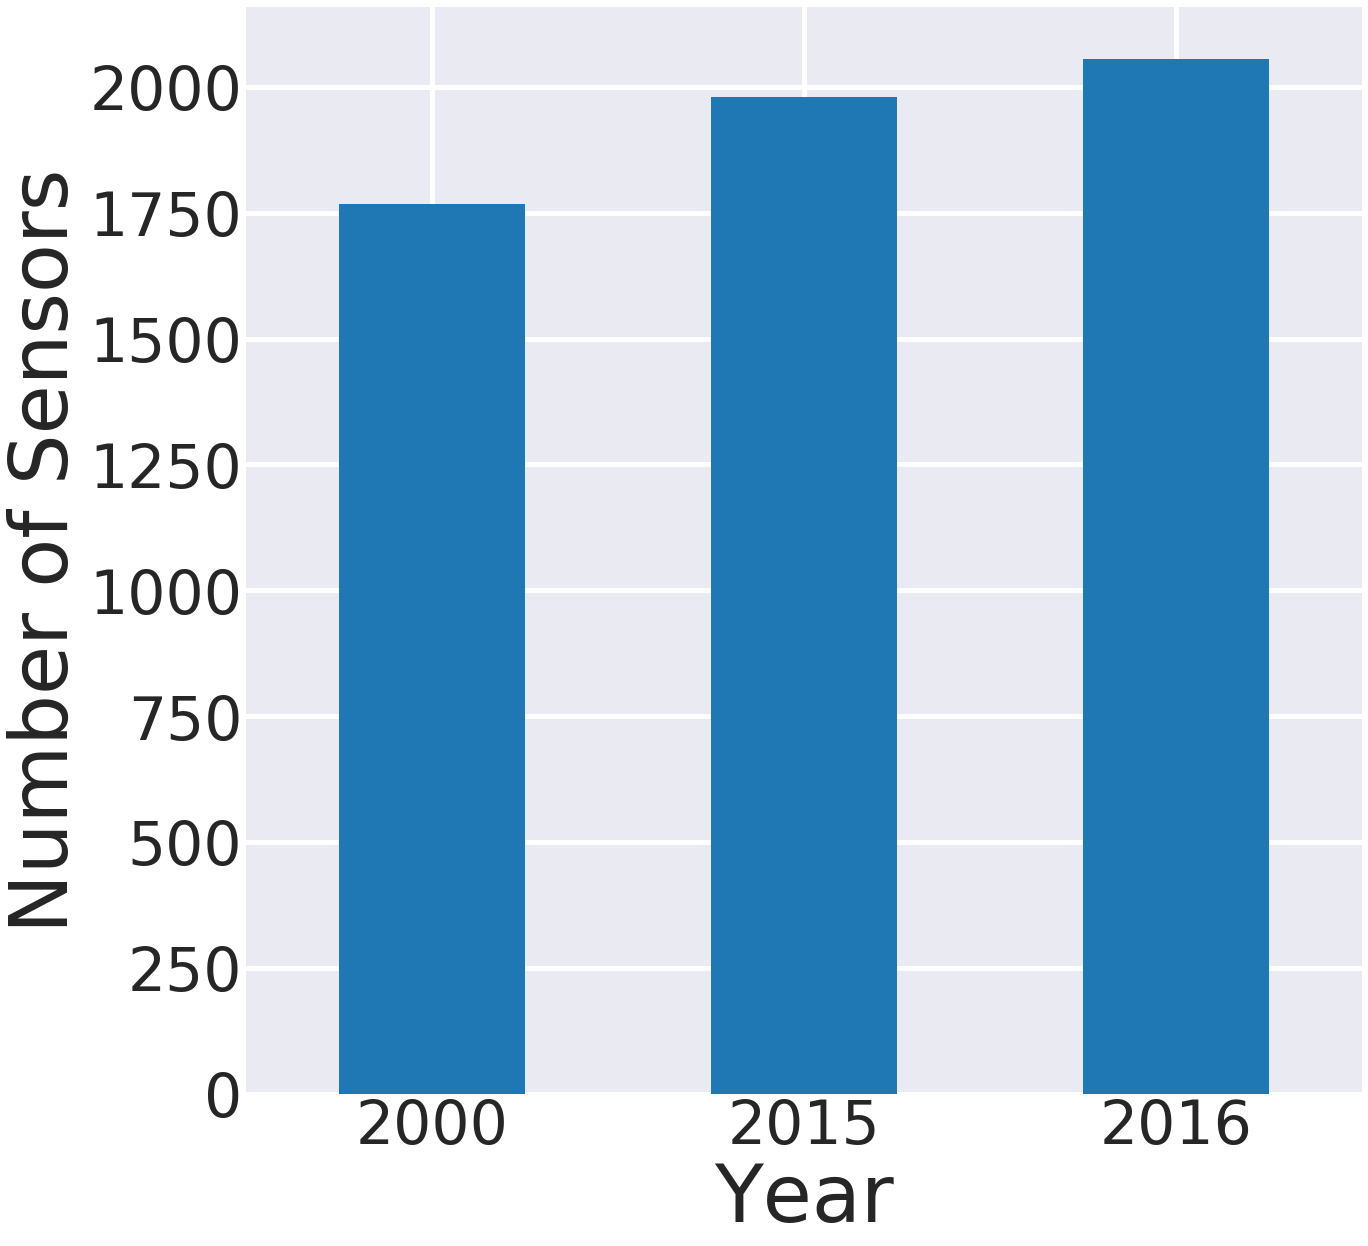

In [8]:
%%local
sensor_count_plot = sensor_count_df.set_index("date").plot.bar(
    figsize=(20, 20), 
    fontsize=tick_size, 
    linewidth=line_width * 0.5
)


sensor_count_plot.legend().set_visible(False)
sensor_count_plot.grid(linewidth=5)
sensor_count_plot.set_xlabel("Year", {'size':xlabel_size})
sensor_count_plot.set_ylabel("Number of Sensors", {'size':ylabel_size})
sensor_count_plot.set_xticklabels(sensor_count_plot.get_xticklabels(), rotation=0)

In [5]:
combine_date = udf(lambda year, month: str(year) + "-" + str(month), StringType())
data_grouped_by_month_df = df_raw.select(
    year(col('Timestamp')).alias('year'), 
    month(col('Timestamp')).alias('month')) \
    .groupBy('year', 'month').count() \
    .withColumn('date', combine_date('year', 'month')).sort('year', 'month') \
    .select('date', 'count')

In [30]:
%%spark -o data_grouped_by_year_df
data_grouped_by_year_df = df_raw.select(
    year(col('Timestamp')).alias('year')
).groupBy('year').count().sort('year')

[Text(0,0,u'2005'),
 Text(0,0,u'2006'),
 Text(0,0,u'2007'),
 Text(0,0,u'2008'),
 Text(0,0,u'2009'),
 Text(0,0,u'2010'),
 Text(0,0,u'2011'),
 Text(0,0,u'2012'),
 Text(0,0,u'2013'),
 Text(0,0,u'2014'),
 Text(0,0,u'2015'),
 Text(0,0,u'2016')]

200.0 1
400.0 1
600.0 1
800.0 1
1.0 1
1.2 1
200.0 1
400.0 1
600.0 1
800.0 1
1.0 1
1.2 1
200.0 1
400.0 1
600.0 1
800.0 1
1.0 1
1.2 1
200.0 1
400.0 1
600.0 1
800.0 1
1.0 1
1.2 1


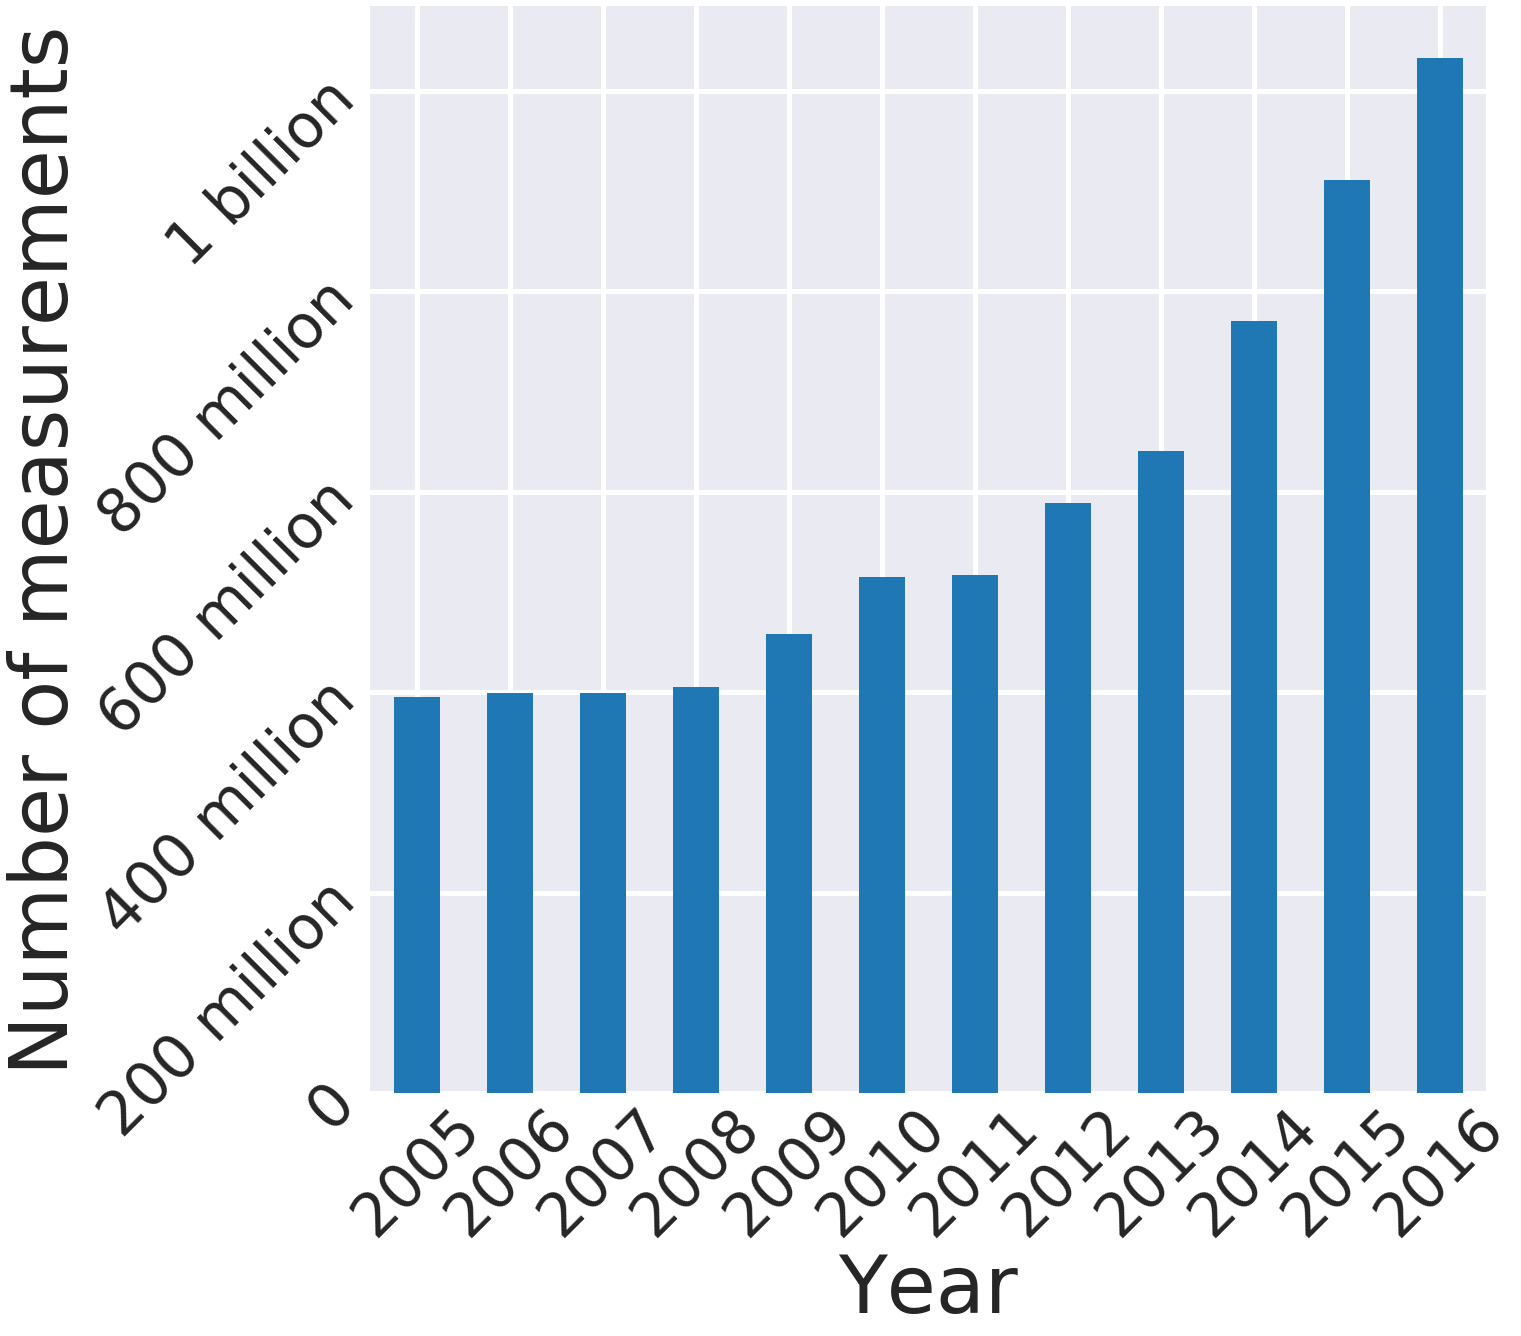

In [84]:
%%local
from matplotlib.ticker import FuncFormatter
def y_fmt(y, pos):
    scales = [1e9, 1e6]
    suffix  = ["billion", "million"]
    if y == 0:
        return str(0)
    for i, d in enumerate(scales):
        if np.abs(y) >=d:
            val = y/float(d)
            signf = len(str(val).split(".")[1])
            if signf == 0:
                return '{val:d} {suffix}'.format(val=int(val), suffix=suffix[i])
            else:
                if signf == 1:
                    print val, signf
                    if str(val).split(".")[1] == "0":
                        return '{val:d} {suffix}'.format(val=int(round(val)), suffix=suffix[i]) 
                tx = "{"+"val:.{signf}f".format(signf = signf) +"} {suffix}"
                return tx.format(val=val, suffix=suffix[i])

                #return y
    return y

data_grouped_by_year_plot = data_grouped_by_year_df.plot(
    kind="bar", 
    figsize=(20, 20), 
    x="year", 
    logy=False,
    fontsize=tick_size, 
    linewidth=line_width * 0.5
)

data_grouped_by_year_plot.legend().set_visible(False)
data_grouped_by_year_plot.yaxis.set_major_formatter(FuncFormatter(y_fmt))
yticks = data_grouped_by_year_plot.yaxis.get_major_ticks()
ytick_locs = data_grouped_by_year_plot.yaxis.get_major_locator()

plt.yticks(rotation=45)
data_grouped_by_year_plot.grid(linewidth=5)
data_grouped_by_year_plot.set_xlabel("Year", {'size':xlabel_size})
data_grouped_by_year_plot.set_ylabel("Number of measurements", {'size':ylabel_size})
data_grouped_by_year_plot.set_xticklabels(data_grouped_by_year_plot.get_xticklabels(), rotation=45)